****Challenge Data has*** 182000  rows and  3   columns  ******
****Challenge label has*** 2000  rows and  2   columns  ******
****Merged label data has*** 182000  rows and  4   columns  ******
***Unique Labels*** [ True False]


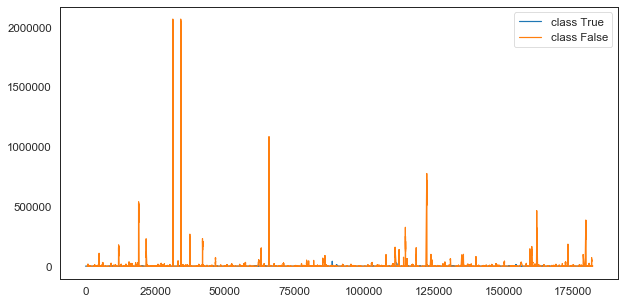

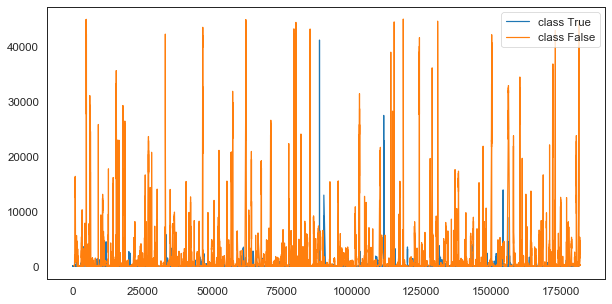

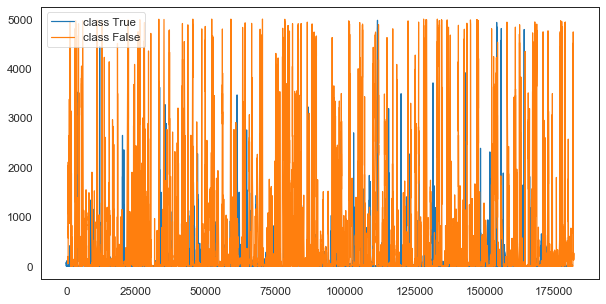

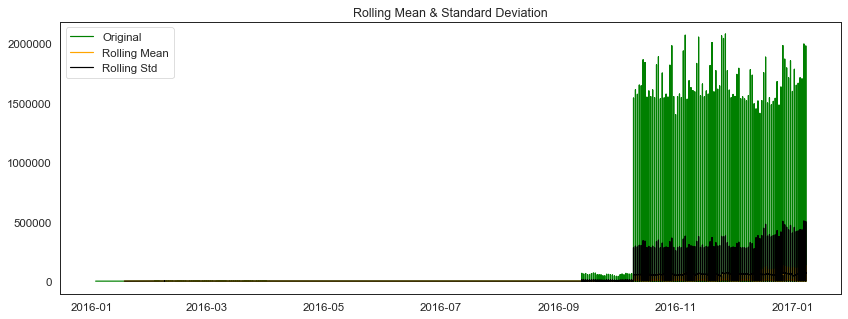

<Results of Dickey-Fuller Test>
Test Statistic                   -47.0199
p-value                            0.0000
#Lags Used                        78.0000
Number of Observations Used   182059.0000
Critical Value (1%)               -3.4304
Critical Value (5%)               -2.8616
Critical Value (10%)              -2.5668
dtype: float64
+----------------------------+------------------+
| Daily Summary Statistics   |            value |
|----------------------------+------------------|
| count                      | 182138           |
| mean                       |   4700.92        |
| std                        |  60817.4         |
| min                        |      0           |
| 25%                        |      0           |
| 50%                        |      2           |
| 75%                        |     88           |
| max                        |      2.07698e+06 |
+----------------------------+------------------+
*****aggregated features per day*****
*********************

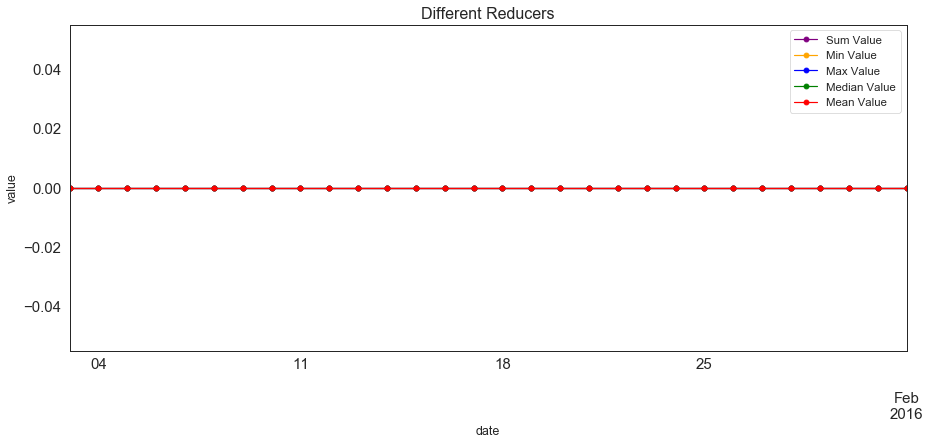

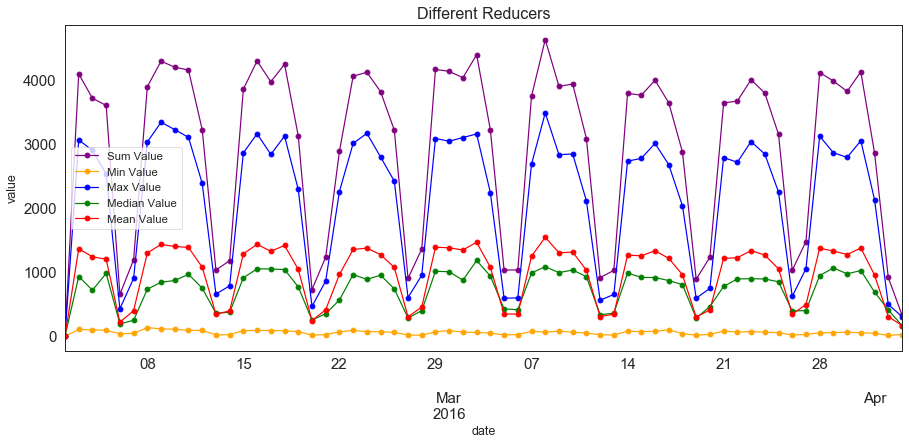

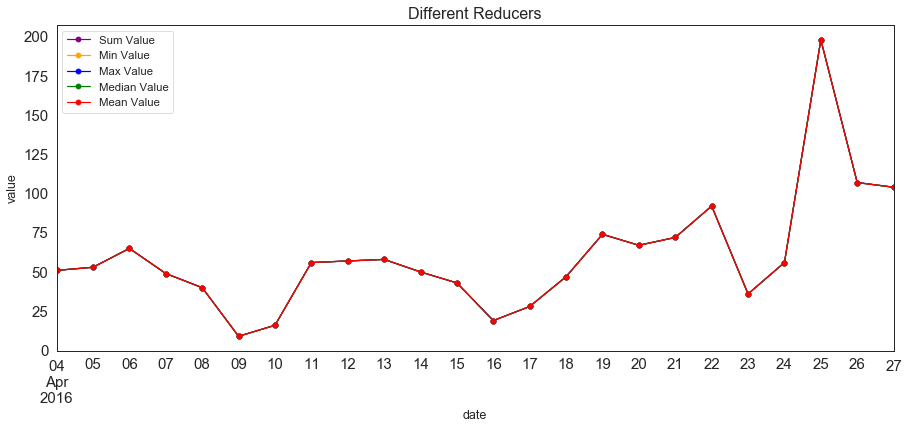

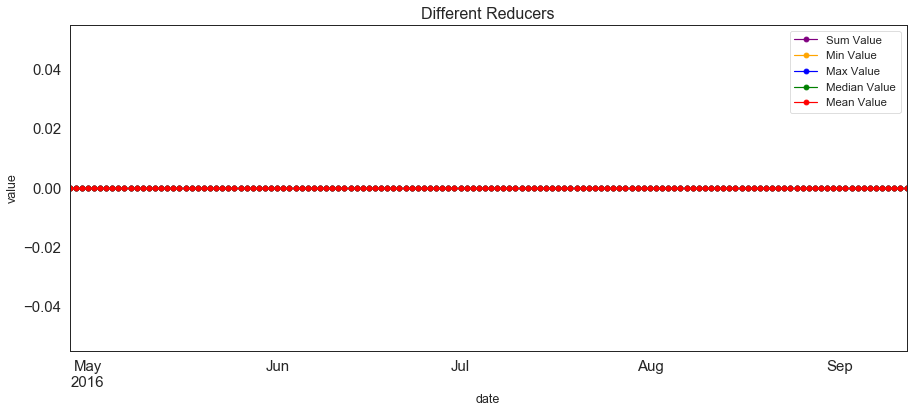

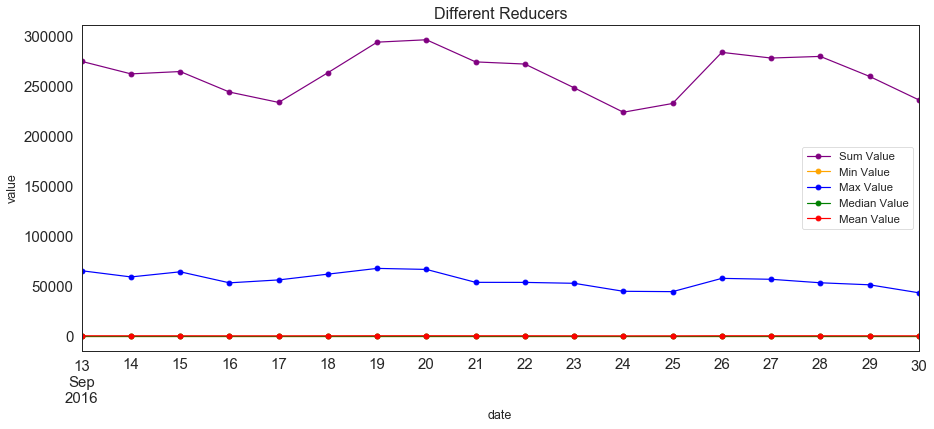

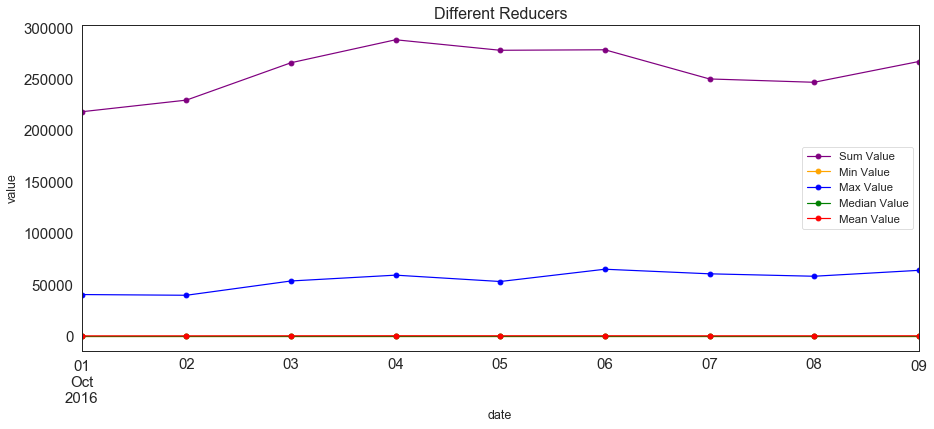

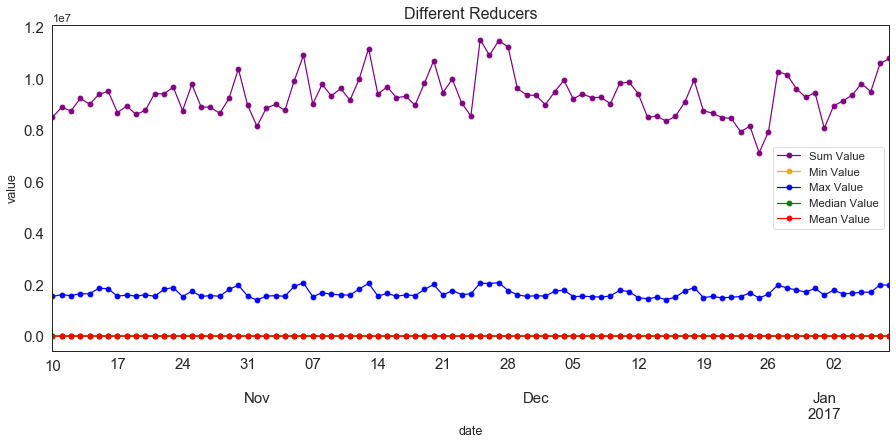

Mon, 05 Apr 2021 01:37:11 +0000
Total time taken(in seconds)->  127.02943420410156


In [96]:
#%%
# This script implements EDA for challenge data
# Idea is to build a classifier for Outlier.
# It's an open ended problem in terms of what classifier we are trying to build.
# Data exploration provided the data landscape about noisy vs non-noisy data 

__author__ = "Minakshi Mukherjee"



import seaborn as sns
import numpy as np 
import pandas as pd 
import pymysql
import matplotlib.pyplot as plt
import time
import warnings
import Access_module
import importlib
from datetime import datetime, date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc,roc_auc_score
from matplotlib import pyplot as plt, style
from tabulate import tabulate
from time import gmtime, strftime
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")


# This Function convers a date into datetime format
def parser(x):
    
    return datetime.strptime(x, '%Y-%m-%d')

# This Function ingests time series csv data and uses the parser to convert a date into datetime format
# The output is a dataframe
def ingest_timeseries_data(file):
    df = pd.read_csv(file, header=0, parse_dates=[1], squeeze=True, date_parser=parser)   
    
    return df

# This Function ingests csv data 
# The output is a dataframe
def ingest_data(file):
    df = pd.read_csv(file, header=0, squeeze=True)   
    
    return df

# This Function accepts start_date and end_date of a timeseries, the datetime indexed
# dataframe, name of the date column and name of the value column
# The output is a timeseries dataframe with continuous time
def make_timeseries_continuous(start_date,end_date,df,val_date,val_col):
    df_temp = df.reset_index(drop=True)
    df_daily = df_temp.set_index([val_date])
    df_daily.index.name = None
    
    dailyTimestamp = pd.date_range(start = start_date, end = end_date, freq = 'D')
    startDay = dailyTimestamp
    endDay = dailyTimestamp + np.timedelta64(1,'D')
    dailyTime = pd.DataFrame(data = np.transpose([startDay, endDay]), index = dailyTimestamp, columns = ['startDay', 'endDay'])
    
    df_cont = df_daily.join(dailyTime, how = 'outer')
    df_cont[val_col].fillna(0, inplace=True)
    df_cont.sort_index(inplace = True)
    
    return df_cont

# This Function takes a dataframe and the name of the value column 
# It prints the 5-number statistical summary in a nice tabular format
def summary_statistics_tabular(df,val_col):
    dc = pd.DataFrame(df[val_col].describe())
    dc.index.name = 'Daily Summary Statistics'
    print(tabulate(dc, headers='keys', tablefmt='psql'))
    
# Plot daily timeseries for sum of values
# It accepts the dataframe and a value column
def plot_daily(df1, val_col):
    plt.figure()
    fig = df1[val_col].plot(color = 'purple', marker = 'o',label='Value',fontsize = 15, figsize = (15, 6))
    
    plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
    plt.title('Aggregated Daily Value', fontsize = 16)
    plt.legend(loc="best")
    plt.ylabel('value')
    plt.show()
        
# Plot daily timeseries data with all the reducers
# It accepts the dataframes for five reducers and produce timeseries plots
def plot_reducer_daily(df1, range1, range2):
    plt.figure()
    
    sub_df1 = df1[(df1['date'] >= range1) & (df1['date'] <= range2)]
    sub_df1 = sub_df1.set_index(['date'])
    
    fig = sub_df1['sum'].plot(color = 'purple', marker = 'o',label='Sum Value',fontsize = 15, figsize = (15, 6))
    fig = sub_df1['min'].plot(color = 'orange', marker = 'o',label='Min Value',fontsize = 15, figsize = (15, 6))
    fig = sub_df1['max'].plot(color = 'blue', marker = 'o',label='Max Value',fontsize = 15, figsize = (15, 6))
    fig = sub_df1['median'].plot(color = 'green', marker = 'o',label='Median Value',fontsize = 15, figsize = (15, 6))
    fig = sub_df1['mean'].plot(color = 'red', marker = 'o',label='Mean Value',fontsize = 15, figsize = (15, 6))
    
    plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
    plt.title('Different Reducers', fontsize = 16)
    plt.legend(loc="best")
    plt.ylabel('value')
    plt.show()
    
# Test Stationarity of timeseries data
# It accepts a series containing the values and tests data stationarity using Dickey-Fuller test
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    plt.figure(figsize=(14,5))
    orig = plt.plot(timeseries, color='green',label='Original')
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
# It sets up the maximum display if output is viwed in notebook
def setup():
    pd.set_option('display.max_rows', 3000)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    sns.set_context("paper", font_scale=1.3)
    sns.set_style('white')
    
    
def merge_dataframe(df1, df2):
    df_merge = pd.merge(df1, df2, how='left')
    
    return df_merge    
    
# It plots the color coded labels to display the noise/value distribution
# It accepts the merged dataframe and the distinct labels in the data
# It also takes the inteher range of values for the plot for good viewing
def plot_noise_label(df_merge, classes, int_val, val_col):
    plt.figure(figsize=(10,5))
    for c in classes:
        c_plot = df_merge[(df_merge.label == c) & (df_merge.value < int_val)][val_col]
        plt.plot(c_plot, label="class " + str(c))
    plt.legend(loc="best")
    plt.show()
        
# Prepare six reducers and concatenate them
def generate_reducers(df_cont):
    c_sum = df_cont.resample('D').sum().rename(columns={'value': 'sum'})
    c_min = df_cont.resample('D').min().rename(columns={'value': 'min'})
    c_max = df_cont.resample('D').max().rename(columns={'value': 'max'})
    c_median = df_cont.resample('D').median().rename(columns={'value': 'median'})
    c_mean = df_cont.resample('D').mean().rename(columns={'value': 'mean'})
    c_count = df_cont.resample('D').count().rename(columns={'value': 'count'})

    frames = [c_sum, c_min, c_max, c_median, c_mean, c_count]    
    df_add = pd.concat(frames, axis=1)
    df_add = df_add[['sum', 'min', 'max', 'median','mean', 'count']].reset_index().rename(columns={'index': 'date'})
    
    return df_add

# Create target based on count of True and False
def prob(col1,col2):
    if col1 >col2: # True > False
        encode=1
    else:
        encode=0
        
    return encode

# Add time based feature
def add_time_feature(df, date_col):
    df['year'] = df[date_col].apply(lambda x: x.year)
    df['dayofmonth'] = df[date_col].apply(lambda x: x.day)
    df['dayofweek'] = df[date_col].apply(lambda x: x.dayofweek)
    df['dayofyear'] = df[date_col].apply(lambda x: x.dayofyear)
    df['weekofyear'] = df[date_col].apply(lambda x: x.weekofyear)
    
    return df

# Extract features for ML model
def extract_feature(labelled_data, reducer_data, date_col):
    df_feature = labelled_data[[date_col, True, False]]
    df_feature = merge_dataframe(reducer_data, df_feature).fillna(0)
    df_feature['encoded_label'] = df_feature.apply(lambda x: prob(x[True], x[False]), axis=1)   
    df_feature = add_time_feature(df_feature, 'date')

    return df_feature

# Build features for new data to predict
def new_predict_feature(filename):
    predict_data = ingest_timeseries_data(filename)
    predict_data_cont = make_timeseries_continuous(predict_data['date'].min(),predict_data['date'].max()\
                                                     ,predict_data,'date','value')
    print("****Predict Data has***",predict_data_cont.shape[0], " rows and ",predict_data_cont.shape[1], "  columns ", "******")
    feature_add = generate_reducers(predict_data_cont)
    feature_add = add_time_feature(feature_add, 'date')
    pred_df = feature_add[['sum','year','dayofmonth','dayofweek','dayofyear','weekofyear']]
    
    return pred_df

# main     
if __name__ == "__main__":
    start = time.time()
    
    setup()
    ######################## INGEST DATA ##################################
    challenge_data = ingest_timeseries_data('challenge-data.csv')
    print("****Challenge Data has***",challenge_data.shape[0], " rows and ",challenge_data.shape[1], "  columns ", "******")
    challenge_label = ingest_data('challenge-labels.csv')
    print("****Challenge label has***",challenge_label.shape[0], " rows and ",challenge_label.shape[1], "  columns ", "******")
    challenge_data_merge = merge_dataframe(challenge_label, challenge_data)
    print("****Merged label data has***",challenge_data_merge.shape[0], " rows and ",challenge_data_merge.shape[1], "  columns ", "******")
    classes = challenge_label['label'].unique()
    print("***Unique Labels***", classes)

    ########################  PLOT NOISY DATA ###############################
    plot_noise_label(challenge_data_merge, classes, max(challenge_data_merge.value),'value')
    plot_noise_label(challenge_data_merge, classes, 45000, 'value')
    plot_noise_label(challenge_data_merge, classes, 5000, 'value')

    ########################  MAKE TIMESERIES DATA CONTINUOUS ###############################
    challenge_data_cont = make_timeseries_continuous(challenge_data['date'].min(),challenge_data['date'].max()\
                                                     ,challenge_data,'date','value')
    challenge_data_merge_cont = make_timeseries_continuous(challenge_data['date'].min(),challenge_data['date'].max()\
                                                     ,challenge_data_merge,'date','value')
    
    ########################  TEST STATIONARITY  ###############################
    test_stationarity(challenge_data_cont.value)
    summary_statistics_tabular(challenge_data_cont,'value') 

    ########################  GENERATE REDUCERS PER DAY ###############################
    df_add = generate_reducers(challenge_data_cont)
    print("*****aggregated features per day*****")
    print("*************************************")
    print( df_add.tail())

    plot_reducer_daily(df_add,'2016-01-01', '2016-02-01' )
    plot_reducer_daily(df_add,'2016-02-02', '2016-04-03' )
    plot_reducer_daily(df_add,'2016-04-04', '2016-04-27' )
    plot_reducer_daily(df_add,'2016-04-28', '2016-09-12' )
    plot_reducer_daily(df_add,'2016-09-13', '2016-09-30' )
    plot_reducer_daily(df_add,'2016-10-01', '2016-10-09' )
    plot_reducer_daily(df_add,'2016-10-10', '2017-01-15' ) 

    ########################  EXTRACT FEATURES FOR MODEL BUILDING ###############################
    challenge_data_label = challenge_data_merge.groupby('date')['label'].value_counts().unstack().fillna(0).reset_index().reset_index()
    ml_input_df = extract_feature(challenge_data_label, df_add, 'date')
    ml_input_df.to_pickle('ml_input_df_final.pickle')
    
    end = time.time()
    print(strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime()))
    print("Total time taken(in seconds)-> ", end-start)

In [97]:
predict_df = new_predict_feature('challenge_predict.csv')
print(predict_df)
predict_df.to_pickle('predict_df.pickle')

****Predict Data has*** 12  rows and  4   columns  ******
      sum  year  dayofmonth  dayofweek  dayofyear  weekofyear
0   15427  2017           8          6          8           1
1    8356  2017           9          0          9           2
2  124654  2017          10          1         10           2
3   80793  2017          11          2         11           2
